## Tuto fonction fastmri

## Import

In [1]:
import sys
sys.path.append('/home/lo276838/Modèles/mri-dl-recon/src/mri_dlrecon')

In [2]:
from fastmri.data import transforms as T
import torch
import numpy as np
from matplotlib import pyplot as plt

from utils_torch import virtual_coil_reconstruction, show_coils, load_and_transform, create_zero_filled_reconstruction
from fastmri.data.subsample import create_mask_for_mask_type
from fastmri.models.unet import Unet

Pré-condition pour l'affichage des images

In [3]:
plt.rcParams['figure.figsize'] = (5, 5)
plt.rcParams['image.cmap'] = 'gray'

## Download data 

In [4]:
file_path = "/volatile/FastMRI/brain_multicoil_train/multicoil_train/file_brain_AXT1POST_201_6002780.h5"
kspace_multicoil = load_and_transform(file_path)
images_multicoil = torch.fft.fftshift(torch.fft.ifft2(kspace_multicoil))
images_multicoil.shape

torch.Size([16, 16, 640, 320])

Show all coils from the image

In [5]:
# images_slices = images_multicoil[images_multicoil.shape[1]-1] 

# for coil_index in range(images_slices.shape[0]):
#     show_coils(np.log(np.abs(images_slices) + 1e-9), [coil_index])

Les données sont complex.  
Shape = [Batch , coils , H, W]

## Multicoil to Singlecoil

In [6]:
image = virtual_coil_reconstruction(images_multicoil)
image.shape

torch.Size([16, 640, 320])

In [7]:
kspace = torch.fft.fft2(image)
kspace.shape

torch.Size([16, 640, 320])

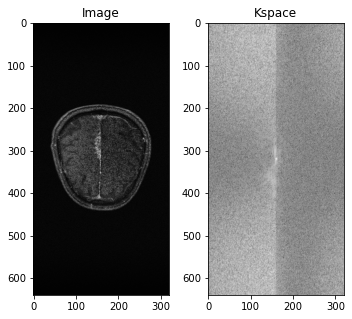

In [8]:
plt.subplot(1,2,1)
plt.imshow(np.abs(image[0, :,: ].numpy()))
plt.title("Image")

plt.subplot(1,2,2)
plt.imshow(np.log(np.abs(kspace[0, :, :])))
plt.title("Kspace")

plt.tight_layout()
plt.show()

## Test for undersampling Mask 

### Fastmri

Choose the sampling mask you want between the following.

random : genere a sampling mask randomly  
equispaced : genere a sampling mask with qually-spaced k-space lines  
equispaced_fraction : similar to equispaced with more precision about acceleration rate  
magic : genere a sampling mask who exploit conjugate symmetry  
magic_fraction : similar to magic with more precision about acceleration rate  

In [9]:
mask_type = "magic_fraction"
center_fractions = [0.08, 0.04]
accelerations = [4, 8]

mask = create_mask_for_mask_type(mask_type, center_fractions, accelerations)

masked_func represent here the binary data of the mask.   
0 mean informatiosn in the data are note conserve.   
1 mean you take the information.   
    
accelerated_data is the fusion between the original data and sampling data.   
This is the data we gonna use.

In [18]:
zero_filled_reconstruction = torch.fft.fftshift(create_zero_filled_reconstruction(mask, kspace))

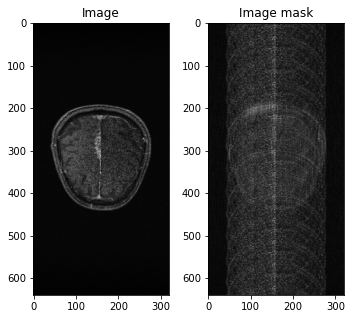

In [19]:
plt.subplot(1,2,1)
plt.imshow(np.abs(image[0, :,: ].numpy()))
plt.title("Image")

plt.subplot(1,2,2)
plt.imshow(np.abs(zero_filled_reconstruction[0, 0, :,: ].numpy()))
plt.title("Image mask")

plt.tight_layout()
plt.show()

### Fasmri Reproductible Benchmark

In [12]:
from data.gen_mask_torch import gen_mask_torch

In [21]:
#  Representation binaire qui indique quel point sera conservé. 

masked_data = gen_mask_torch(kspace, accel_factor= 4 , multicoil= False , fixed_masks=False)
masked_kspace = kspace* masked_data

In [25]:
zero_filled = torch.fft.ifft2(masked_kspace)

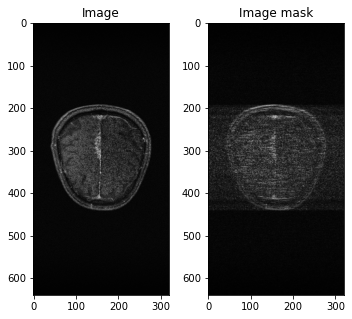

In [26]:
plt.subplot(1,2,1)
plt.imshow(np.abs(image[0, :,: ].numpy()))
plt.title("Image")

plt.subplot(1,2,2)
plt.imshow(np.abs(zero_filled[0, :,: ].numpy()))
plt.title("Image mask")

plt.tight_layout()
plt.show()